<img src="https://www.mines.edu/webcentral/wp-content/uploads/sites/267/2019/02/horizontallightbackground.jpg" width="100%"> 
### CSCI250 Python Computing: Building a Sensor System
<hr style="height:5px" width="100%" align="left">

# LAB: Game of Life
## Jacob States

# Introduction

The goal of this lab is to simulate the concept of parallel worlds based on the famous [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life). We will simulate a scenario of two parallel universes which function based on the rules of the game, but which exchange information (in one direction) at various times. This scenario will give us an opportunity to use Python concurrent execution, i.e. use separate threads to simulate "life" in each universe, and use queues to exchange information between the universes.

<img src="https://www.dropbox.com/s/u628vjn2uc5h3ua/notebook.png?raw=1" width="10%" align="right">

Read through
* the  [2D arrays notebook](s_NpArrays2D.ipynb) 
* the  [2D plot notebook](s_NpPlots2D.ipynb)
* the  [concurrency notebook](s_NpConcurrency.ipynb)
* the  [animation notebook](s_MpAnimation.ipynb)

# Game of Life

The game is a [cellular automaton](https://en.wikipedia.org/wiki/Cellular_automaton) based on the following rules:
1. Any live cell with fewer than two live neighbors dies, as if by underpopulation.
* Any live cell with two or three live neighbors **lives** on to the next generation.
* Any live cell with more than three live neighbors dies, as if by overpopulation.
* Any dead cell with exactly three live neighbors becomes a **live** cell, as if by reproduction.

# Assignment

1. Implement the basic logic of the Game of Life. In this step, you will work with a single universe and you do not need to use concurrency (we will later use threading to simulate the game in multiple universes). Use vectorization whenever possible to achieve the fastest implementation possible.
    * simulate the transformation of the game field from one generation to another
    * generate an entire cube representing the field at multiple generations (e.g. 100).
    * plot an animation of the simulation (see below).
    
2. Implement separate functions corresponding to a producer and a consumer that share information using a queue. The logic is the following:
    * The **producer** inserts a specific shape at random locations in its field
        * for simplicity, the producer uses only the "glider" shape (see below)
        * add the glider to the field only at 10% of the time steps selected randomly
        
    and puts into a queue at every generation its index and a flag
        * the boolean flag specifies if at least 25 cells are alive in its field at that time

    * The **consumer** receives the information from the queue and
        * inserts a glider into the field at a random position every time the received flag is `True`.
        * Once a glider is inserted, the consumer does not insert another one for at least 5 generations
    
    and advances using the GoL logic, like the producer.
    
Thus, the producer and the consumer fields evolve by the same rules. 

They also exchange information (from the producer to the consumer) at specific times according to the rules specified before (i.e. the flag is `True` at all generations when the producer field has 25 live cells).

3. Launch the producer and the consumer in separate threads
    * use a queue to pass information from one thread to another
    * start both threads at the same time (i.e. in very close succession)

4. Plot side-by-side an animation of the two fields, thus visualizing the moments when information is exchanged  between the two universes (from the producer to the consumer).

# Glider

Is a specific shape we will insert into the GoL field. This shape has properties that make the animation interesting, i.e. the shape moves as it changes over generations.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng

import matplotlib.animation as ani
from IPython.display import HTML

plt.set_cmap('Blues')

<Figure size 640x480 with 0 Axes>

In [33]:
def glider(A, iR,iC):
    A[iR  ,iC-2] += 1
    A[iR  ,iC-1] += 1
    A[iR  ,iC  ] += 1
    A[iR-1,iC  ] += 1
    A[iR-2,iC-1] += 1

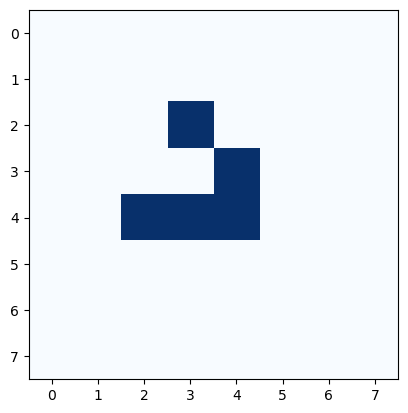

In [34]:
nR,nC = 8,8

A = np.zeros( [nR,nC], dtype=int)

glider(A, 4,4)

plt.imshow(A)

In [41]:
def NBS(A):
    nR,nC = A.shape
    K = np.zeros( [nR,nC], dtype=int)
    
    for iR in range(nR):
        jR = max([iR-1, 0])
        kR = min([iR+1,nR]) + 1
        
        for iC in range(nC):
            jC = max([iC-1, 0])
            kC = min([iC+1, nC]) + 1
            K[iR,iC] = np.sum( A[ jR:kR, jC:kC]) - A[iR,iC]
    
    return K

In [42]:
K = NBS(A)

print(K)
print(A)

[[0 0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0 0]
 [0 0 1 1 2 1 0 0]
 [0 1 3 5 3 2 0 0]
 [0 1 1 3 2 2 0 0]
 [0 1 2 3 2 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


<AxesSubplot:>

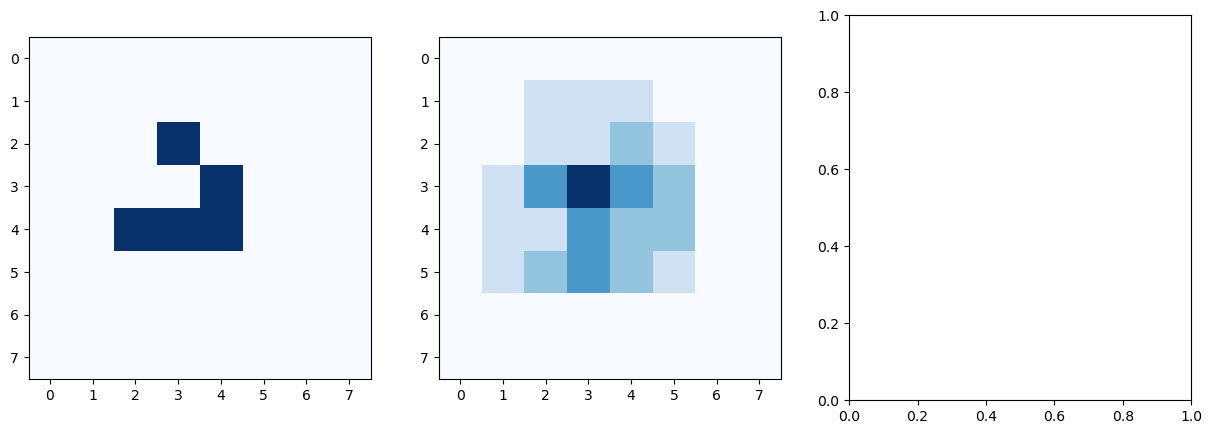

In [43]:
plt.figure(figsize =(15,5))

plt.subplot(1,3,1)
plt.imshow(A)

plt.subplot(1,3,2)
plt.imshow(K)

plt.subplot(1,3,3)

# Animation

Upon completion of the GoL simulation you should have a 3D `numpy` array called `MOVIE` with  $nR$ rows, $nC$ columns, and nSteps slices. 

The following demonstrates how to animate a 3D array - in this case, we will simply add random numbers at various steps. 

In [4]:
nR = 31
nC = 31
nT = 101

MOVIE = np.zeros( [nR,nC,nT], dtype=int)

for iT in range(nT-1):
    iR = rng.randint(1,nR-1)
    iC = rng.randint(1,nC-1)
    MOVIE[iR,iC,iT] = 1

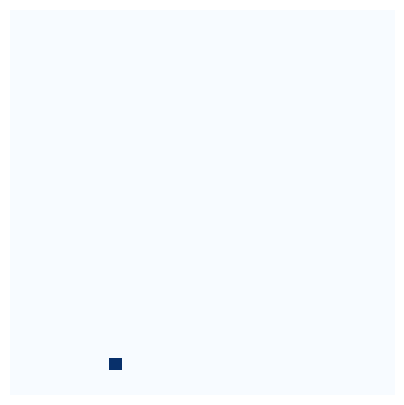

In [8]:
golFig = plt.figure(figsize=(5,5)); # create figure

golPlot = plt.imshow(MOVIE[:,:,0]);   # make a plot
plt.axis('off');

In [9]:
# define animation function
def golAnimate(i, MOVIE, golP):
    golP.set_data( MOVIE[:,:,i] )
    plt.axis('off')

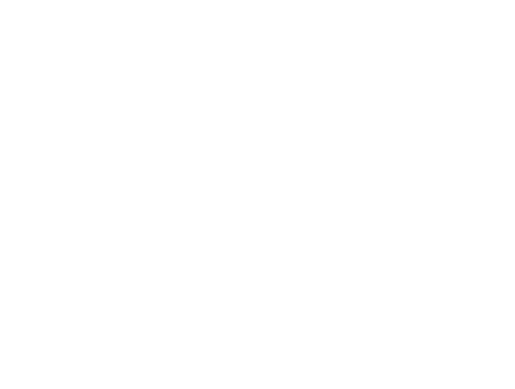

In [10]:
# create inline animation
golMovie = ani.FuncAnimation(fig    = golFig, 
                             func   = golAnimate, 
                             frames = nT,
                             fargs  = (MOVIE,golPlot)
                             );

HTML(golMovie.to_jshtml())       # Java script version (don't use on RPi)
# HTML(rawkMovie.to_html5_video()) # HTML 5 (use on RPi)

# Extra credit

Implement the logic of this exercise using more than 2 universes.

Pass information in both directions between two communicating universes.

# Post lab

<img src="http://www.dropbox.com/s/fcucolyuzdjl80k/todo.jpg?raw=1" width="10%" align="right">

Before you submit the lab, make sure everything works as you expect by restarting the kernel: select **Kernel > Restart & Run All**.

Answer the following questions.

1. What elements of this lab did you find easy/challenging?
    * Your answer here
2. What did you like/dislike about this lab?
    * Your answer here
3. If you did anything worthy of extra credit, tell us about it here!
    * Your answer here

# Submit
* Make sure to update your name and department in the top markdown cell.

* Rename the Jupyter notebook with the following convention:
**SL?-FirstLast.ipynb** (replace ? with the lab number)

* Turn in your Jupyter notebook on Canvas. Email submissions don't count.

# Honor code
Unless explicitly specified, labs are **individual exercises**. Your submission is subject to the [**Mines Honor Code**](http://inside.mines.edu/~epoeter/_GW/CSMHonorCodeUndergradHandbook.pdf).